### Full Name : Mahdi Tabatabaei 
### Student Number : 400101515


# Support Vector Machines (SVM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

## Goal
In this assignment, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

In [2]:
df = pd.read_csv("Liver_Disease.csv")

### Pre-Processing

#### Exploratory Data Analysis:
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

In [3]:
# Find the shape of the dataset.
df.shape

(583, 11)

In [4]:
# Check if there is missing entries in the dataset columnwise.
print(df.isnull().sum())

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
label                         0
dtype: int64


In [5]:
# Check if the dataset is balanced or not
if 'label' in df.columns:
    print("Label class distribution:")
    print(df['label'].value_counts())
else:
    print("No Label column found in the dataset.")

Label class distribution:
label
1    416
2    167
Name: count, dtype: int64


The dataset is imbalanced and number of datapoints with label 1 is more than twice of datapoints with label 2.

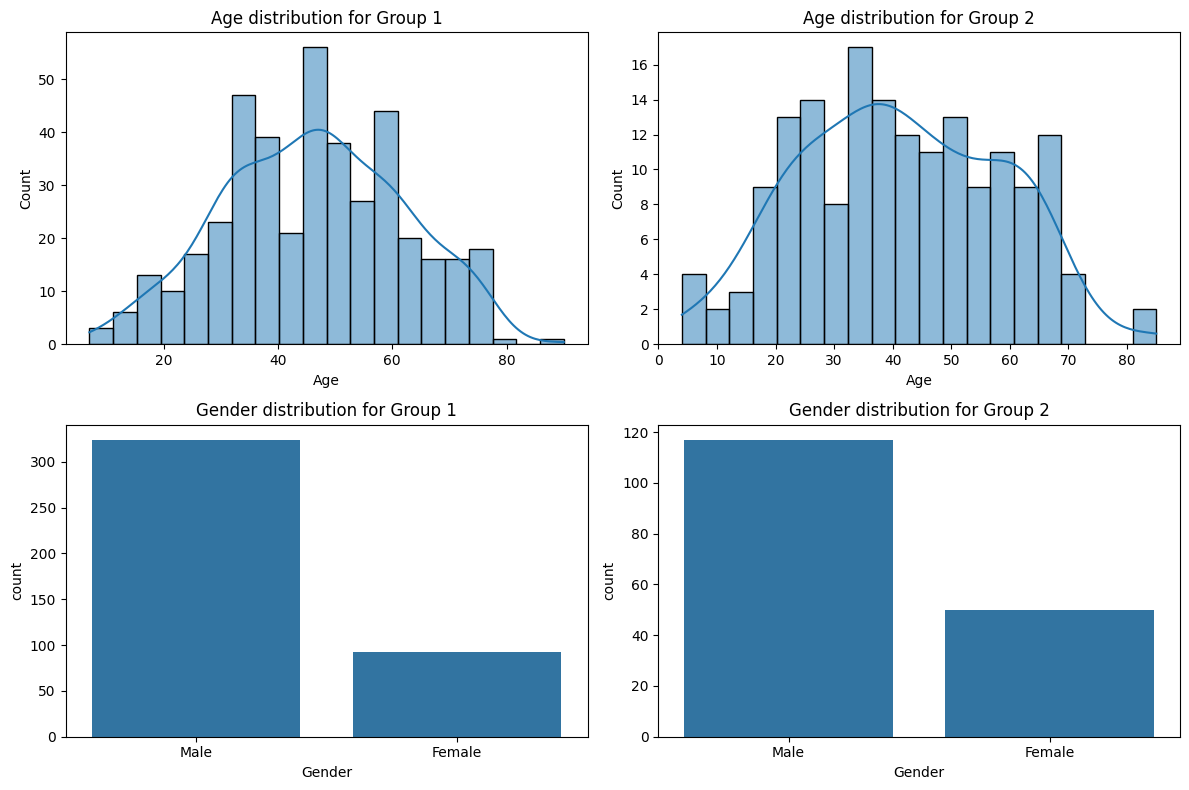

In [6]:
# 4. plot the age distirbution and gender distrbution for both group of patients.(4 plots)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Age distribution for group 1
sns.histplot(df[df['label'] == 1]['Age'], bins=20, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Age distribution for Group 1')

# Age distribution for group 0
sns.histplot(df[df['label'] == 2]['Age'], bins=20, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Age distribution for Group 2')

# Gender distribution for group 1
sns.countplot(x='Gender', data=df[df['label'] == 1], order = ['Male', 'Female'], ax=axs[1, 0])
axs[1, 0].set_title('Gender distribution for Group 1')

# Gender distribution for group 0
sns.countplot(x='Gender', data=df[df['label'] == 2], ax=axs[1, 1])
axs[1, 1].set_title('Gender distribution for Group 2')

plt.tight_layout()
plt.show()

##### Question: What do you conclude from the plots?

- **Age Distribution:** Group 1 consists primarily of middle-aged to older individuals, while Group 2 has a higher proportion of younger individuals. This suggests potential differences in health conditions or risk factors associated with different age groups.
  
- **Gender Distribution:** Both groups are predominantly male, with a more significant gender imbalance in Group 1 compared to Group 2. This may indicate that the condition being studied disproportionately affects males, or there could be sampling bias toward male patients.


#### Outlier Detection & Removal
Check whether we have outliers in the data. If there are, delete them.

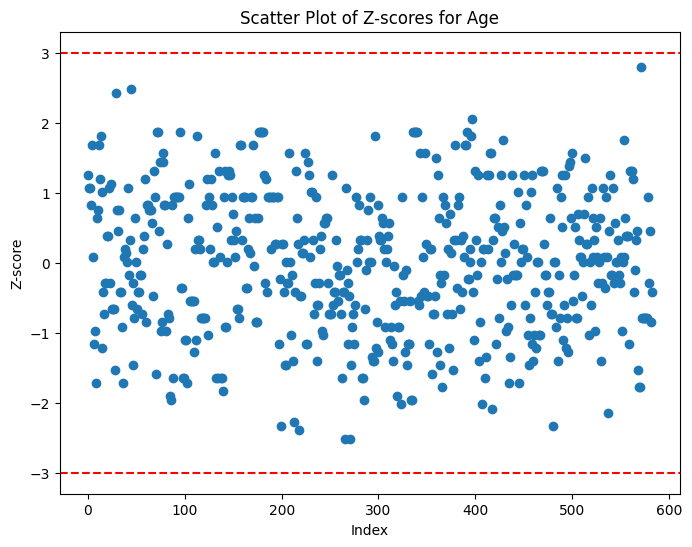

In [7]:
import pandas as pd
from scipy import stats

df_to_check = df.copy()
# Calculate the z-scores for the 'age' column
df_to_check['z_score_age'] = stats.zscore(df_to_check['Age'])
# Scatter plot to visualize Z-scores for age
plt.figure(figsize=(8, 6))
plt.scatter(df_to_check.index, df_to_check['z_score_age'])
plt.axhline(y=3, color='r', linestyle='--')
plt.axhline(y=-3, color='r', linestyle='--')
plt.title('Scatter Plot of Z-scores for Age')
plt.ylabel('Z-score')
plt.xlabel('Index')
plt.show()

I have analyzed the dataset for outliers using three methods: **Z-score**, **IQR method**, and **Tukey's fences**. It appears that there are no detected outliers in the dataset based on age using any of these methods.

In [8]:
# Reimporting necessary libraries and loading the dataset again
import pandas as pd
from scipy import stats

# Calculate z-scores for all numerical columns in the dataset
numerical_columns = df_to_check.select_dtypes(include=['float64', 'int64']).columns

# Function to calculate outliers based on Z-scores for all columns
def detect_outliers_zscore(df, columns, threshold=3):
    outliers = pd.DataFrame()
    for column in columns:
        z_scores = stats.zscore(df[column])
        df['z_score_' + column] = z_scores
        outliers_for_column = df[(z_scores > threshold) | (z_scores < -threshold)][[column, 'z_score_' + column]]
        if not outliers_for_column.empty:
            outliers = pd.concat([outliers, outliers_for_column], axis=0)
    return outliers

# Detect outliers in all numerical columns using Z-scores
z_score_outliers_all_columns = detect_outliers_zscore(df_to_check, numerical_columns)

# Remove the detected outliers from the original dataframe
df = df.drop(z_score_outliers_all_columns.index)

In [8]:
# Reimport necessary libraries and load the dataset again
import pandas as pd

# Define function to detect outliers based on IQR for specified columns
def detect_outliers_iqr(df, columns, lower_quantile=0.1, upper_quantile=0.9, factor=1.5):
    outliers = pd.DataFrame()
    for column in columns:
        Q1 = df[column].quantile(lower_quantile)
        Q3 = df[column].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        outliers_for_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)][[column]]
        if not outliers_for_column.empty:
            outliers = pd.concat([outliers, outliers_for_column], axis=0)
    return outliers

# Calculate the numerical columns
numerical_columns = df_to_check.select_dtypes(include=['float64', 'int64']).columns

# Detect outliers in all numerical columns using IQR
iqr_outliers_all_columns = detect_outliers_iqr(df_to_check, numerical_columns)

# Remove the detected outliers from the original dataframe
df = df_to_check.drop(iqr_outliers_all_columns.index)

I have dropped 45 datapoints from my dataset by z-score analyzing.

In [9]:
df.shape

(526, 12)

#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.
also feel free to do more feature engineering techniques if needed.

In [10]:
# Normalize numerical features to be between 0 and 1                   
# Note that just numerical fetures should be normalized.    
from sklearn.preprocessing import MinMaxScaler

# Define the label column (replace 'label' with the actual name if different)
label_column = 'label'

# Select only the numerical columns excluding the label column
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.difference([label_column])

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the numerical features to be between 0 and 1 (excluding the label)
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])              

Set Male and Female to 1 and 0

In [11]:
# Convert 'Male' to 1 and 'Female' to 0
df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})

# Verify the conversion
print(df['Gender'].value_counts())

Gender
1    395
0    131
Name: count, dtype: int64


In [12]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,label,z_score_age
0,0.709302,0,0.016667,0.000000,0.125633,0.020134,0.018561,0.594203,0.521739,0.37500,1,0.709302
1,0.674419,1,0.583333,0.606742,0.644377,0.181208,0.208817,0.695652,0.500000,0.27500,1,0.674419
2,0.674419,1,0.383333,0.449438,0.432624,0.167785,0.134571,0.623188,0.521739,0.36875,1,0.674419
3,0.627907,1,0.033333,0.033708,0.120567,0.013423,0.023202,0.594203,0.543478,0.43750,1,0.627907
4,0.790698,1,0.194444,0.213483,0.133739,0.057047,0.113689,0.666667,0.326087,0.06250,1,0.790698


Set labels 1, 0 instead of 1, 2

In [13]:
# Convert labels 2 to 0 (assuming 1 is the positive class and 2 is the negative class)
df['label'] = df['label'].replace({2: 0})

# Verify the conversion
print(df['label'].value_counts())

label
1    360
0    166
Name: count, dtype: int64


Removing rows which contain Nan input.

In [14]:
# Drop all rows that contain NaN values
df = df.dropna()
df.shape

(522, 12)

### SVM

#### spliting data

In [15]:
# Split the data into test and training sets.

from sklearn.model_selection import train_test_split

# Define the features and label
X = df.drop(columns=['label'])  # Features (all columns except the label)
y = df['label']  # Label (target)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets to verify the split
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training features shape: (417, 11)
Testing features shape: (105, 11)
Training labels shape: (417,)
Testing labels shape: (105,)


### SVM using Scikit-Learn:
First of all train an svm model with default parameters and report its.

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the SVM classifier
svm_model = SVC()

# Train the SVM model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.6857142857142857
Confusion Matrix:
[[ 0 33]
 [ 0 72]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.69      1.00      0.81        72

    accuracy                           0.69       105
   macro avg       0.34      0.50      0.41       105
weighted avg       0.47      0.69      0.56       105



#### Grid Search
Use Grid search and validation set to find the best parameters for your SVM model.

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split

# Split the training data into training and validation sets (80% train, 20% validation)
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient for 'rbf'
    'class_weight': [None, 'balanced']
}

# Initialize the SVM model
svm_model = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_part, y_train_part)

# Output the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
val_score = best_model.score(X_val, y_val)
print(f"Validation accuracy with best parameters: {val_score}")


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters found: {'C': 100, 'class_weight': None, 'gamma': 0.1, 'kernel': 'sigmoid'}
Validation accuracy with best parameters: 0.6547619047619048


Train an svm model on the entire training data using the parameters you found in the previous step.

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the SVM model with the best parameters from the grid search
svm_model_best = SVC(**best_params)

# Train the SVM model on the entire training dataset
svm_model_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = svm_model_best.predict(X_test)

# Evaluate the model performance on the test data
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

# Output the test accuracy, confusion matrix, and classification report
print(f"Test accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Test accuracy: 0.7047619047619048
Confusion Matrix:
[[ 3 30]
 [ 1 71]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.09      0.16        33
           1       0.70      0.99      0.82        72

    accuracy                           0.70       105
   macro avg       0.73      0.54      0.49       105
weighted avg       0.72      0.70      0.61       105



### Confusion Matrix
Plot the confusion matrix and report the model accuracy on test set.
What does each entry of the confusion matrix mean?

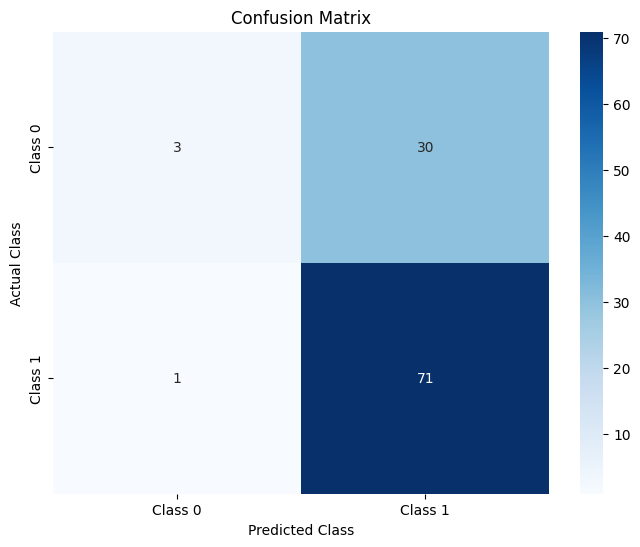

Test Accuracy: 0.7048


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming y_test and y_pred_test are already defined from the previous steps

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create labels for the confusion matrix
labels = ['Class 0', 'Class 1']

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_test)

# Print the accuracy
print(f"Test Accuracy: {accuracy:.4f}")


**Entry of confusion matrix**

**Top-left (TN)**: The model correctly predicted Class 0 when the actual class was Class 0.

**Top-right (FP)**: The model incorrectly predicted Class 1 when the actual class was Class 0.

**Bottom-left (FN)**: The model incorrectly predicted Class 0 when the actual class was Class 1.

**Bottom-right (TP)**: The model correctly predicted Class 1 when the actual class was Class 1.

Add some outliers to the dataset, train an SVM and logistic regression model, and compare the results.

We add 5 oiutliers to the dataset

In [20]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Step 1: Add some outliers to the dataset

# Create a copy of the cleaned dataset
df_outliers = df.copy()

# Introduce outliers in a few random rows by adding large values to some numerical columns
np.random.seed(42)
outlier_indices = np.random.choice(df_outliers.index, size=5, replace=False)

# Add extreme values to some columns for these selected rows
df_outliers.loc[outlier_indices, 'Total_Bilirubin'] *= 10  # Exaggerate Total Bilirubin values for these rows
df_outliers.loc[outlier_indices, 'Alkaline_Phosphotase'] *= 20  # Exaggerate Alkaline Phosphotase values for these rows

# Step 2: Train an SVM Model with the dataset containing outliers
X_outliers = df_outliers.drop(columns=['label'])
y_outliers = df_outliers['label']

# Split the dataset into training and test sets
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_outliers, y_outliers, test_size=0.2, random_state=42)

# Train an SVM model
svm_model = SVC(C=100, kernel='sigmoid', gamma=0.1, class_weight=None)
svm_model.fit(X_train_out, y_train_out)
y_pred_svm = svm_model.predict(X_test_out)

# Step 3: Train a Logistic Regression Model with the same dataset
log_reg_model = LogisticRegression(max_iter=100, class_weight=None)
log_reg_model.fit(X_train_out, y_train_out)
y_pred_logreg = log_reg_model.predict(X_test_out)

# Step 4: Compare the results of both models

# SVM Results
accuracy_svm = accuracy_score(y_test_out, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test_out, y_pred_svm)
class_report_svm = classification_report(y_test_out, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm}")
print("SVM Confusion Matrix:")
print(conf_matrix_svm)
print("SVM Classification Report:")
print(class_report_svm)

# Logistic Regression Results
accuracy_logreg = accuracy_score(y_test_out, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test_out, y_pred_logreg)
class_report_logreg = classification_report(y_test_out, y_pred_logreg)

print(f"Logistic Regression Accuracy: {accuracy_logreg}")
print("Logistic Regression Confusion Matrix:")
print(conf_matrix_logreg)
print("Logistic Regression Classification Report:")
print(class_report_logreg)


SVM Accuracy: 0.7047619047619048
SVM Confusion Matrix:
[[ 3 30]
 [ 1 71]]
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.09      0.16        33
           1       0.70      0.99      0.82        72

    accuracy                           0.70       105
   macro avg       0.73      0.54      0.49       105
weighted avg       0.72      0.70      0.61       105

Logistic Regression Accuracy: 0.7047619047619048
Logistic Regression Confusion Matrix:
[[ 5 28]
 [ 3 69]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.15      0.24        33
           1       0.71      0.96      0.82        72

    accuracy                           0.70       105
   macro avg       0.67      0.55      0.53       105
weighted avg       0.68      0.70      0.64       105



Logistic Regression and SVM performs equally in case of accuracy, but precision for SVM is higher.